# Week 2 - Classical ML Models

## 1. Linear Regression
In Linear Regression, we assume a linear relationship between one or more independent variables $x_i$ and a single dependent variable $y$. A linear regression model therefore tries to predict the value of $y$ from a linear combination of the input variables $x_i$. In a simple linear regression, the predicted value of $y$ ($\hat{y}$) depends only on a single input variable $x_i$. In other words, $\hat{y}$ can be expressed as $\theta_0+\theta_1x$, where $\theta_0$ and $\theta_1$ are constants (model parameters). More generally, a linear model might have more than 1 independent variables, in which case we can write the previous expression as:

$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2x_2 + ... + \theta_nx_n$$

This form can be rather tedious to write out when $n$ is large, so we can express this in a vectorized form: $\hat{y} = \theta^T x$, where $x$ is a vector containing $x_0$, $x_1$, ... $x_n$, where $x_0$ is always set to 1 (for multiplication with the bias term), and $\theta$ is a column vector containing the model parameters $\theta_0$, $\theta_1$,..., $\theta_n$.

### 1.1 Simple Linear Regression Example

In [2]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Suppose we have the data of the advertising budget for product A's television commercials in a certain market (in thousands of dollars), and the corresponding sales in the said market (in thousands of units). 

Source: Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. An Introduction to Statistical Learning :
with Applications in R. New York:Springer, 2013

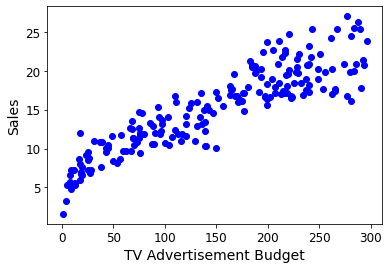

In [3]:
df = pd.read_csv("advertising.csv")
X = df['TV'].to_numpy().reshape(-1, 1)
y = df['Sales'].to_numpy().reshape(-1, 1)

plt.scatter(X, y, c='b')
plt.ylabel("Sales")
plt.xlabel("TV Advertisement Budget")
plt.show()

There is a little noise, but the data looks linear. Now we would like to fit a best-fit line through the data points. The equation of the best-fit line is given as $y$ = $\theta_0 + \theta_1x$. But how do we find out what the best values for $\theta_0$ and $\theta_1$ are? 

### 1.2 Random Guess

In this example, we only have two parameters $\theta_0$ and $\theta_1$ that define our linear regression model. Since we don't have any better idea right now, how about we just take a random guess? Let's try $\theta_0 = 10$ and $\theta_1 = 0.02$ and plot the resulting line:

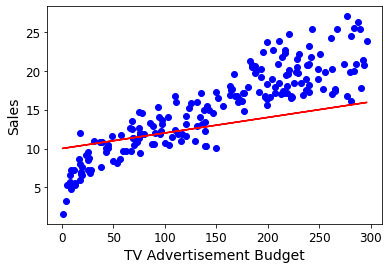

In [4]:
plt.scatter(X, y, c='b')

theta_1 = 0.02
theta_0 = 10
y_pred = X * theta_1 + theta_0

plt.plot(X, y_pred, "r-")
plt.ylabel("Sales")
plt.xlabel("TV Advertisement Budget")
plt.show()

That's not terrible for a guess, but our slope is too small. If we were to do better, it might be useful to define some kind of a *cost function* that defines how far off our predictions were from the actual data. For linear regression model, the most natural / common cost function to use is the **Mean Squared Error (MSE)**. Mathematically, MSE is defined as following:

$$mse(\theta) = \frac{1}{m} \sum_{i=1}^{m} ((\theta_0 + \theta_1 x_i) - y_i)^2$$

$y$ is a *vector* of $y_1$, $y_2$... $y_m$, where $y_i$ is the value of the dependent variable (Sales in thousand units in our example) for the $i^{th}$ data instance.

Let's now calculate the MSE of our prediction: 

In [5]:
mse = np.mean((y_pred - y) ** 2)
mse

19.23676878

### 1.3 Closed-form solution

If you know a bit of linear algebra, you might know that there is a *closed-form* solution to the least-squares problem that gives us the optimal values for $a$ and $b$. We won't go through the proof here, but interested students can check out Lecture 15 of Gilbert Strang's wonderful Linear Algebra lecture series on Youtube. Here is the equation (called the *Normal Equation*) for obtaining the optimal $\theta$ that minimizes the squared loss of our best-fit line:

$$\theta = (X^T X)^{-1} X^T y $$

$X$ is a *matrix* form of the input variables of dimensions $m$ by $n$, where $m$ is the number of data instances (i.e. `len(df)` in our case, $m=200$) and $n$ is the dimension of the feature vectors (for our simple linear regression example, we have $n=2$: $x_1$ representing the TV advertising budget and $x_0$ which is always 1 for the bias term).

Don't worry if you don't get why this works, as this isn't a linear algebra course! That said, we'll continue with the code now to show that the above equation does indeed lead you to an optimal solution:

In [6]:
X_bias = np.concatenate((np.ones((len(X), 1)), X), axis = 1) # X with 1 (for bias term) added 

best_theta = np.linalg.inv(X_bias.T.dot(X_bias)).dot(X_bias.T.dot(y))

In [7]:
best_theta

array([[6.97482149],
       [0.05546477]])

Using the Normal Equation, we get $\theta_0=6.97482149$ and $\theta_1=0.05546477$. Let's plot the resulting line:

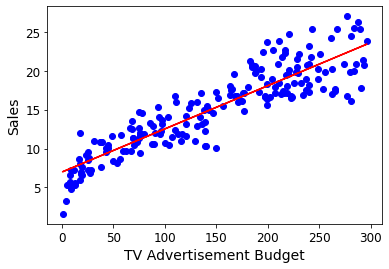

In [8]:
plt.scatter(X, y, c='b')
plt.plot(X, X_bias.dot(best_theta), "r-")
plt.ylabel("Sales")
plt.xlabel("TV Advertisement Budget")
plt.show()

### 1.4 Linear Regression with Gradient Descent

A problem with calculating the closed-form solution problems like above is that the computation cost of calculating it does not scale efficiently as the number of independent variables increases. In most real-world data, we usually have many independent variables which could affect $y$ in various ways. If we have $k$ such independent variables, then the computational cost of finding the closed-form solution is dominated by the calculation of the inverse of $X^T X$, which is $O(k^3)$. For most real-world data, this is too computationally expensive.

Instead, we can train our linear regression model gradually, using a technique called **gradient descent**. We explore gradient descent in much more detail next week, but for now you can think of it as an optimization algorithm that iteratively modifies parameters in way that minimizes a predefined cost function. It does so by finding the derivative of the cost function with regards to the said parameters, which tells the algorithm mathematically how to change each parameter to result in a smaller cost.

Now let's derive the derivative of our MSE loss with respect to $\theta_0$ and $\theta_1$. Recall that MSE is expressed as:

$$mse(\theta) = \frac{1}{m} \sum_{i=1}^{m} ((\theta_0 + \theta_1 x_i) - y_i)^2$$

Let's now compute the partial derivate of the loss with regard to parameter $\theta_0$, our bias term:

$$\frac{\partial mse(\theta)}{\partial \theta_0} = \frac{2}{m}\sum_{i=1}^{m}  ((\theta_0 + \theta_1 x_i) - y_i) \cdot 1 $$

And the partial derivate of the loss with regard to parameter $\theta_1$:

$$\frac{\partial mse(\theta)}{\partial \theta_1} = \frac{2}{m} \sum_{i=1}^{m} ((\theta_0 + \theta_1 x_i) - y_i) \cdot x_i$$


Here is our update rule for the parameters $\theta_0$ and $\theta_1$ at iteration $t$, using gradient descent:

$$\theta_i^{(t+1)} = \theta_i^t - \eta \cdot \frac{\partial mse(\theta)}{\partial \theta_i} $$

where $\eta$ is what's called the **learning rate**, which we'll learn about when we explore gradient descent in-depth next week.

Now, let's look at the code for fitting a linear regression model with gradient descent:

Before we optimise with gradient descent, we are going to use `scikit-learn`'s `StandardScaler` to scale our independent variable before adding the bias terms. Otherwise, you'll find that you'll need to use an extremely low learning rate to train the model properly. While we could have used a simpler example where all the data are drawn from a standard normal distribution, we wanted to show you that preprocessing is often a very important step in machine learning projects, because the data you're working with can come in any form!

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

In [10]:
lr = 2e-3

def gradient_descent(X, y, learning_rate, record_at, num_iterations = 2000):
    theta_0 = np.zeros((1,1))
    theta_1 = np.zeros((1,1))
    theta_hist = []

    for it in range(num_iterations):
        errors = (X.dot(theta_1) + theta_0) - y
        d_theta_0 = 2/len(errors) * np.sum(errors)
        theta_0 -= learning_rate * d_theta_0
        d_theta_1 = 2/len(errors) * X_scaled.T.dot(errors)
        theta_1 -= learning_rate * d_theta_1

        if it in record_at:
            theta_hist.append((theta_0.copy(), theta_1.copy()))

    return theta_0, theta_1, theta_hist

theta_0, theta_1, theta_hist = gradient_descent(X_scaled, y, lr, [10, 100, 500, 1800])

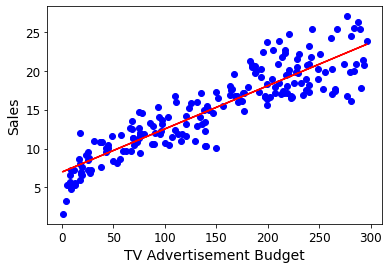

In [11]:
# Get predictions using optimised theta_0 and theta_1 values
y_pred = X_scaled.dot(theta_1) + theta_0

plt.scatter(X, y, c='b')
plt.plot(X, y_pred, "r-")
plt.ylabel("Sales")
plt.xlabel("TV Advertisement Budget")
plt.show()

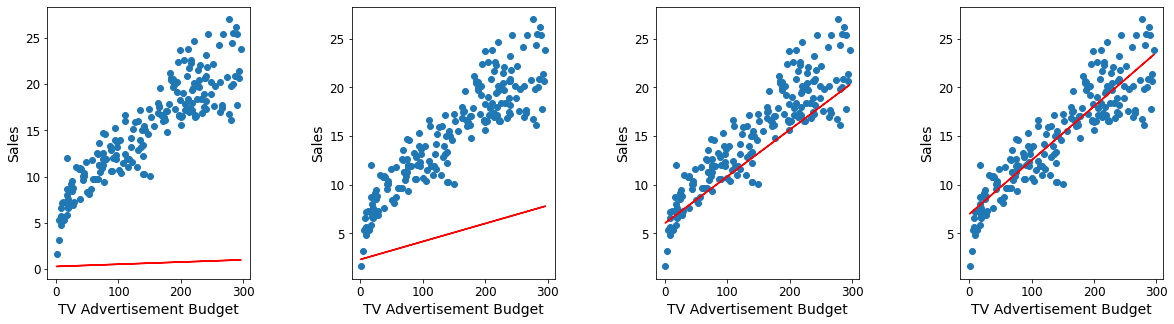

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    theta_0_it, theta_1_it = theta_hist[i]
    y_pred_it = X_scaled.dot(theta_1_it) + theta_0_it
    ax[i].scatter(X, y)
    ax[i].plot(X, y_pred_it, color='r')
    ax[i].set_xlabel('TV Advertisement Budget')
    ax[i].set_ylabel('Sales')

fig.subplots_adjust(wspace=0.5)

plt.show()

Not bad! We successfully trained our linear regression model using gradient descent. Although we derived the mathematical formulas and implemented it from scratch using only `numpy`, in practice you can use the `LinearRegression` (for closed-form solution) and `SGDRegressor` (for linear regression with stochastic gradient descent, which uses mini-batches of data) from scikit-learn.

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

model.coef_, model.intercept_

(array([[0.05546477]]), array([6.97482149]))

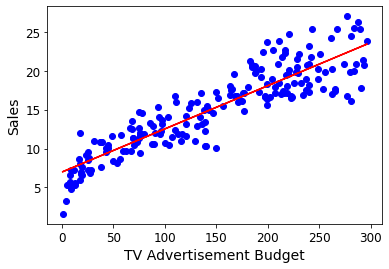

In [14]:
plt.scatter(X, y, c='b')
plt.plot(X, X.dot(model.coef_) + model.intercept_, "r-")
plt.ylabel("Sales")
plt.xlabel("TV Advertisement Budget")
plt.show()